In [66]:
import requests
from IPython.display import JSON
import pandas as pd
import numpy as np 
import time

# Visualization
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

# Panel/hvplot (holoviz)
import panel as pn
pn.extension()
import param
import hvplot.pandas

# Others
import pickle
from io import StringIO

In [67]:
# API secret
#from lib.api_secret import API_KEY

API_KEY = "b9f3bf272d284e5685dc8b4220470855"

## Get audio transcription using AssemblyAI

In [68]:
# Submitting Files for Transcription
import requests
endpoint = "https://api.assemblyai.com/v2/transcript"
json = {
    "audio_url": "https://github.com/ntiragati08/KDM_project/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true",

    "auto_highlights": True,
    "sentiment_analysis": True,
    "auto_chapters": True,
    "iab_categories": True,
}
headers = {
    "authorization": API_KEY,
    "content-type": "application/json"
}
response = requests.post(endpoint, json=json, headers=headers)
print(response.json())

{'id': 'rsj0spxcnz-2b83-40e9-ae48-f7dd9cb9220b', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'queued', 'audio_url': 'https://github.com/ntiragati08/KDM_project/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true', 'text': None, 'words': None, 'utterances': None, 'confidence': None, 'audio_duration': None, 'punctuate': True, 'format_text': True, 'dual_channel': None, 'webhook_url': None, 'webhook_status_code': None, 'webhook_auth': False, 'webhook_auth_header_name': None, 'speed_boost': False, 'auto_highlights_result': None, 'auto_highlights': True, 'audio_start_from': None, 'audio_end_at': None, 'word_boost': [], 'boost_param': None, 'filter_profanity': False, 'redact_pii': False, 'redact_pii_audio': False, 'redact_pii_audio_quality': None, 'redact_pii_policies': None, 'redact_pii_sub': None, 'speaker_labels': False, 'content_safety': False, 'iab_categories': True, 'content_safety_labels': {}, 'iab_categories_result':

In [70]:
# Getting the Transcription Result
result_endpoint = endpoint + "/" + response.json()["id"]
headers_auth = {
    "authorization": API_KEY,
}
transcript_response = requests.get(result_endpoint, headers=headers_auth)
print(transcript_response.json())

# While loop for requesting transcription
while response.json()['status'] != "completed":
    response = requests.get(result_endpoint, headers=headers_auth)
    time.sleep(5)

{'id': 'rsj0spxcnz-2b83-40e9-ae48-f7dd9cb9220b', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'completed', 'audio_url': 'https://github.com/ntiragati08/KDM_project/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true', 'text': "I recently got an amazing opportunity. I've been learning jujitsu, and a friend offered to coach me in exchange for teaching him how to code. At this point in my life where I'm trying to improve my jiu jitsu as quickly as possible, this was an incredible trade for me. In my personal opinion, I was all for it until I had to think about how I'd actually go about teaching someone how to code starting from nothing. I quickly realized that this was going to be a lot harder than I thought. After all, it's been almost ten years since I wrote my very first line of code. That's a pretty long time. Now, this video is about the very specific and detailed plan that I wrote for my friend to teach me the basic

In [71]:
JSON(transcript_response.json())

<IPython.core.display.JSON object>

In [72]:
# Save pickle
with open('speech_data.pkl', 'wb') as f:
    pickle.dump(transcript_response.json().copy(), f)

## Dashboard components

In [73]:
# Load data pickle
with open('speech_data.pkl', 'rb') as f:
    data = pickle.load(f)

### 0) Download transcript widget

In [74]:
buffer = StringIO()
buffer.write(data["text"])
buffer.seek(0)

0

In [75]:
transcript_download = pn.widgets.FileDownload(file=buffer, 
                                              filename="transcript.txt", 
                                              button_type='success')
transcript_download

FileDownload(button_type='success', file=<_io.StringIO o..., filename='transcript.txt', label='Download transcript.txt')

### 00) Audio play

In [76]:
audio_url = "https://github.com/thu-vu92/audio_analyzer_assemblyai/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true"
audio_play = pn.pane.Audio(audio_url, name='Audio', time = 360)
audio_play

Audio(str, time=360)

### 1) Sentiment plot

In [77]:
sentiment = data["sentiment_analysis_results"]

In [78]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df

,text,start,end,sentiment,confidence,speaker
0,I recently got an amazing opportunity.,237,2032,POSITIVE,0.985436,None
1,"I've been learning jujitsu, and a friend offer...",2185,7282,POSITIVE,0.567717,None
2,At this point in my life where I'm trying to i...,7435,13222,POSITIVE,0.955794,None
3,"In my personal opinion, I was all for it until...",13255,19417,NEUTRAL,0.646500,None
4,I quickly realized that this was going to be a...,19465,22687,NEGATIVE,0.829886,None
...,...,...,...,...,...,...
138,They'll tell you something about what's wrong.,632067,633832,NEUTRAL,0.498572,None
139,"Also, Google the errors, and this will save yo...",633910,637047,POSITIVE,0.568509,None
140,"Finally, the third thing is to take it easy on...",637092,639367,NEUTRAL,0.523670,None
141,The only people that can't code are the ones t...,639490,643732,NEGATIVE,0.902655,None


In [79]:
sentiment_df_grouped = sentiment_df['sentiment'].value_counts()
sentiment_df_grouped

NEUTRAL     77
POSITIVE    52
NEGATIVE    14
Name: sentiment, dtype: int64

In [80]:
# Bar plot
sentiment_plot = sentiment_df_grouped.hvplot(title = "Sentences by Sentiment Category", kind="bar")
pn.Row(sentiment_plot)

Row
    [0] HoloViews(Bars)

In [81]:
positive_df = sentiment_df[sentiment_df["sentiment"] == "POSITIVE"][["text", "sentiment"]]
negative_df = sentiment_df[sentiment_df["sentiment"] == "NEGATIVE"][["text", "sentiment"]]
neutral_df = sentiment_df[sentiment_df["sentiment"] == "NEUTRAL"][["text", "sentiment"]]

sentiment_tabs = pn.Tabs(('Sentiment overview', sentiment_plot), 
                       ('Positive', pn.widgets.DataFrame(positive_df, autosize_mode='fit_columns', width=700, height=300)),
                       ('Negative', pn.widgets.DataFrame(negative_df, autosize_mode='fit_columns', width=700, height=300)),
                       ('Neutral', pn.widgets.DataFrame(neutral_df, autosize_mode='fit_columns', width=700, height=300))
                        )
sentiment_tabs

Tabs
    [0] HoloViews(Bars, name='Sentiment overview')
    [1] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [2] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [3] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)

### 2) Word cloud

In [82]:
stopwords = set(STOPWORDS)

In [83]:
transcript = data["text"]

In [84]:
transcript_lower = [item.lower() for item in str(transcript).split()]
transcript_lower

['i',
 'recently',
 'got',
 'an',
 'amazing',
 'opportunity.',
 "i've",
 'been',
 'learning',
 'jujitsu,',
 'and',
 'a',
 'friend',
 'offered',
 'to',
 'coach',
 'me',
 'in',
 'exchange',
 'for',
 'teaching',
 'him',
 'how',
 'to',
 'code.',
 'at',
 'this',
 'point',
 'in',
 'my',
 'life',
 'where',
 "i'm",
 'trying',
 'to',
 'improve',
 'my',
 'jiu',
 'jitsu',
 'as',
 'quickly',
 'as',
 'possible,',
 'this',
 'was',
 'an',
 'incredible',
 'trade',
 'for',
 'me.',
 'in',
 'my',
 'personal',
 'opinion,',
 'i',
 'was',
 'all',
 'for',
 'it',
 'until',
 'i',
 'had',
 'to',
 'think',
 'about',
 'how',
 "i'd",
 'actually',
 'go',
 'about',
 'teaching',
 'someone',
 'how',
 'to',
 'code',
 'starting',
 'from',
 'nothing.',
 'i',
 'quickly',
 'realized',
 'that',
 'this',
 'was',
 'going',
 'to',
 'be',
 'a',
 'lot',
 'harder',
 'than',
 'i',
 'thought.',
 'after',
 'all,',
 "it's",
 'been',
 'almost',
 'ten',
 'years',
 'since',
 'i',
 'wrote',
 'my',
 'very',
 'first',
 'line',
 'of',
 'cod

In [85]:
all_words = ' '.join(transcript_lower) 
all_words

"i recently got an amazing opportunity. i've been learning jujitsu, and a friend offered to coach me in exchange for teaching him how to code. at this point in my life where i'm trying to improve my jiu jitsu as quickly as possible, this was an incredible trade for me. in my personal opinion, i was all for it until i had to think about how i'd actually go about teaching someone how to code starting from nothing. i quickly realized that this was going to be a lot harder than i thought. after all, it's been almost ten years since i wrote my very first line of code. that's a pretty long time. now, this video is about the very specific and detailed plan that i wrote for my friend to teach me the basics of coding for data science. since i did all the work for him, i figured i might as well share the details with you as well here. there have been plenty of other great videos similar to this about how to start coding, and i've linked many of them in the description. again, those are great, bu

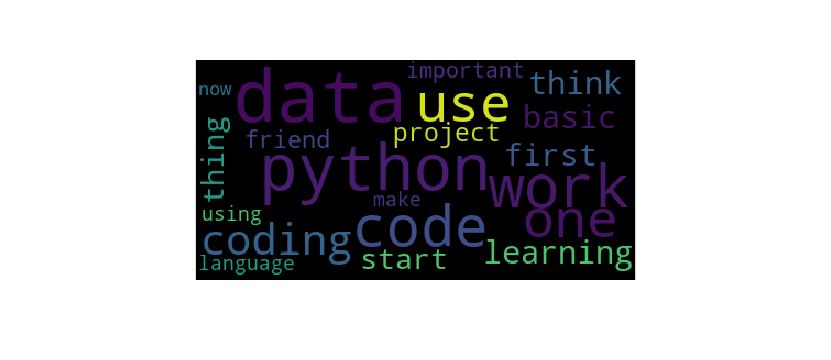

In [86]:
# Word cloud plot
wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = 20,
                      colormap='viridis', collocations=False).generate(all_words)

wordcloud_plot = px.imshow(wordcloud) 
# Remove labels on axes
wordcloud_plot.update_xaxes(showticklabels=False)
wordcloud_plot.update_yaxes(showticklabels=False)
wordcloud_plot

In [87]:
# Create interactive slider
class Controller(param.Parameterized):
    word_slider = param.Integer(30, bounds=(5, 50), step=5)

controller = Controller()

@pn.depends(controller.param.word_slider, watch=True)
def update_wordcloud(num_words):
    # Word cloud plot
    wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = num_words,
                          colormap='viridis', collocations=False).generate(all_words)

    wordcloud_plot = px.imshow(wordcloud) 
    # Remove labels on axes
    wordcloud_plot.update_xaxes(showticklabels=False)
    wordcloud_plot.update_yaxes(showticklabels=False)
    return wordcloud_plot

### 3) Auto chapter summary

In [88]:
chapters = data["chapters"]
chapters

[{'summary': "A friend offered to coach me in exchange for teaching him how to code. It's been almost ten years since I wrote my first line of code. This video is about the detailed plan that I wrote for him to teach me the basics of coding for data science.",
  'headline': 'A friend offered to coach me in exchange for teaching him how to code.',
  'gist': 'How to start coding from nothing.',
  'start': 237,
  'end': 57637},
 {'summary': 'Python is the most popular data science language. According to Stack overflow Developer Survey, 48% of respondents use Python, while only 5% use R. On Kaggle, only 2% of users use Python and 25% of them use R. So some data scientists are using both languages.',
  'headline': 'Some data scientists are using both Python and R as a data science language.',
  'gist': 'Python vs r for data scientists.',
  'start': 57700,
  'end': 128962},
 {'summary': 'After choosing the language as python, the first thing that needs to be done is choosing an environment a

In [89]:
chapter_summary = pn.widgets.StaticText(value=chapters[0]["summary"], 
                                        width=1000, 
                                        height_policy = "fit")
chapter_summary

StaticText(height_policy='fit', value="A friend offered t..., width=1000)

In [90]:
button = pn.widgets.Button(name=str(int(chapters[0]["start"]/1000)), button_type='primary')
button

Button(button_type='primary', name='0')

In [91]:
chapter_audio = pn.pane.Audio(audio_url, name='Audio', time = round(chapters[0]["start"]/1000))
chapter_audio

Audio(str)

In [92]:
# Create chapter summary layout
chapters_layout = pn.Column(pn.pane.Markdown("### Auto Chapter Summary"))

class ButtonAudio():
    def __init__(self, start_time):
        self.start_time = start_time
        self.button = pn.widgets.Button(name=str(int(self.start_time/1000)), button_type='primary', width=60)
        self.chapter_audio = pn.pane.Audio(audio_url, name='Audio', time = round(self.start_time/1000))
        self.button.on_click(self.move_audio_head)

    def move_audio_head(self, event):
        self.chapter_audio.time = self.start_time/1000
        
for chapter in chapters:
    chapter_summary = pn.widgets.StaticText(value=chapter["summary"], width=1000, height_policy = "fit")
    button_audio = ButtonAudio(chapter["start"])
    button = button_audio.button
    chapter_audio = button_audio.chapter_audio
    chapters_layout.append(pn.Row(pn.Column(button), pn.Column(chapter_audio), pn.Column(chapter_summary)))
    
chapters_layout

Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Button(button_type='primary', name='0', width=60)
        [1] Column
            [0] Audio(str)
        [2] Column
            [0] StaticText(height_policy='fit', value="A friend offered t..., width=1000)
    [2] Row
        [0] Column
            [0] Button(button_type='primary', name='57', width=60)
        [1] Column
            [0] Audio(str, time=58)
        [2] Column
            [0] StaticText(height_policy='fit', value='Python is the most popula..., width=1000)
    [3] Row
        [0] Column
            [0] Button(button_type='primary', name='129', width=60)
        [1] Column
            [0] Audio(str, time=129)
        [2] Column
            [0] StaticText(height_policy='fit', value='After choosing the langua..., width=1000)
    [4] Row
        [0] Column
            [0] Button(button_type='primary', name='272', width=60)
        [1] Column
            [0] Audio(str, time=273)
        [2] Column
            [0] StaticText(height_policy='fit', value="There's a common misconce..., width=1000)
    [5] Row
        [0] Column
            [0] Button(button_type='primary', name='522', width=60)
        [1] Column
            [0] Audio(str, time=522)
        [2] Column
            [0] StaticText(height_policy='fit', value='After learning the basics..., width=1000)

### 4) Auto highlights

In [93]:
highlights = data["auto_highlights_result"]["results"]
highlights_df = pd.DataFrame(highlights)
highlights_df

,count,rank,text,timestamps
0,1,0.08,Python code,"[{'start': 270130, 'end': 270862}]"
1,7,0.06,data science,"[{'start': 33370, 'end': 33972}, {'start': 678..."
2,1,0.06,data science learning,"[{'start': 88945, 'end': 89767}]"
3,1,0.06,tangible data science skills,"[{'start': 470140, 'end': 471402}]"
4,1,0.05,data frames,"[{'start': 412420, 'end': 412917}]"
5,1,0.05,data types,"[{'start': 323245, 'end': 323967}]"
6,1,0.05,different data structures,"[{'start': 329470, 'end': 330432}]"
7,1,0.05,other great videos,"[{'start': 38770, 'end': 39532}]"
8,2,0.05,Data scientists,"[{'start': 100405, 'end': 101142}, {'start': 1..."
9,2,0.05,many people,"[{'start': 543057, 'end': 543667}, {'start': 5..."


In [94]:
#scatter plot: to do

## Dashboard

In [95]:
# Dashboard template
template = pn.template.FastListTemplate(
    title='Audio Content Explorer', 
    sidebar=[pn.pane.Markdown("# Explore audio content"), 
             pn.pane.Markdown("#### This app analyzes the content of your audio file, including sentiment, wordcloud, automatic content summary and highlights using AssemblyAI API."),
             pn.pane.Markdown("#### This example is based on the audio content of Ken Jee's Youtube video on how to learn to code."),
             #pn.pane.PNG("kenjee_thumbnail.png", sizing_mode="scale_both"),
             pn.pane.Markdown("### [Link to video!](https://www.youtube.com/watch?v=EBjYqC3aNTA&t=311s)"),
             pn.pane.Markdown("### Download transcript:"),
             transcript_download
             ],
    main=[pn.Row(pn.Column(sentiment_tabs), pn.Column(pn.Row(controller.param.word_slider), 
                                                      pn.Row(update_wordcloud, title = "WordCloud of Speech Content"))
                ),
          pn.Row(chapters_layout)],
    accent_base_color="#88d8b0",
    header_background="#c0b9dd",
)

template.show()

Launching server at http://localhost:57553
